In [1]:
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv("./data/train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train["label"].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
X = train.drop("label", axis=1).values.reshape(-1, 28, 28)
y = train["label"].values

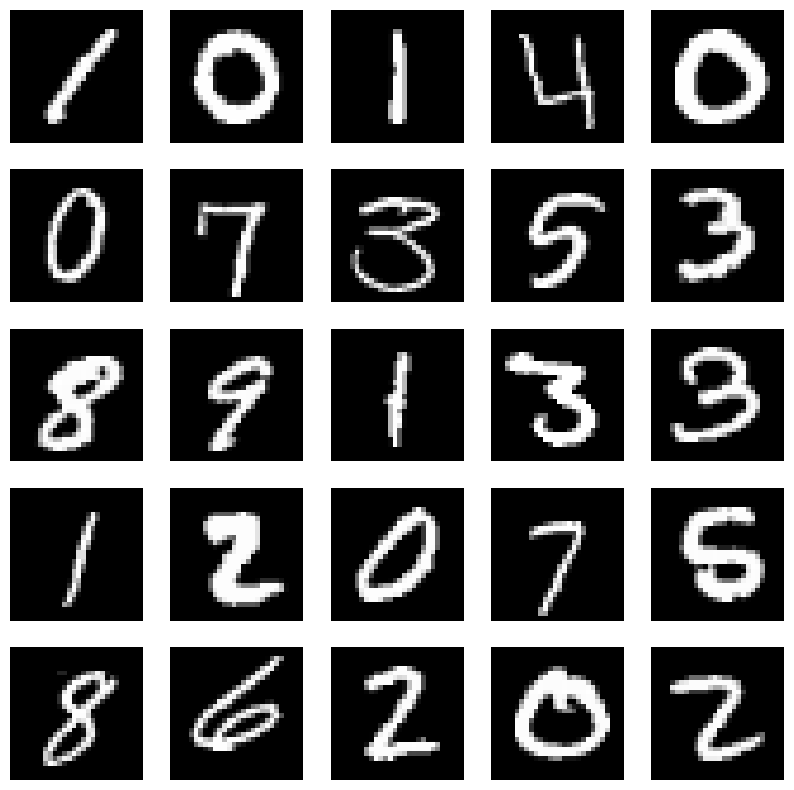

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from torchsummary import summary
from torchviz import make_dot
from contextlib import redirect_stdout
import torch
import torch.nn as nn
import torch.nn.functional as F
import io

C:\Users\palm1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        # Add a channel dimension to the image tensor
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
transform = transforms.Compose(
    [
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


batch_size = 32


train_dataset = MyDataset(data=X_train, labels=y_train, transform=transform)

test_dataset = MyDataset(data=X_test, labels=y_test, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [47]:
filters = 2


class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, filters, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=(2, 2))
        self.fc1 = nn.Linear(filters * 4 * 2 * 2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [48]:
num_classes = 10
model = CustomCNN(num_classes=num_classes)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
print("Model Summary:")
summary(model, input_size=(1, 28, 28))
# with redirect_stdout(io.StringIO()) as f:
#     summary(model, input_size=(1, 28, 28))
# summary_output = f.getvalue()
# desired_output = summary_output.split("\n")[-11:-1]
# print("\n".join(desired_output))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 24, 24]              52
            Conv2d-2            [-1, 4, 10, 10]              76
            Conv2d-3              [-1, 8, 4, 4]             136
            Linear-4                   [-1, 16]             528
            Linear-5                   [-1, 16]             272
            Linear-6                   [-1, 10]             170
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [43]:
# dummy_input = torch.rand(1, 1, 28, 28).to(device)
# model_plot = make_dot(
#     model(dummy_input),
#     params=dict(model.named_parameters()),
# )
# model_plot.render("2dcnn_5x5_32_architecture", format="png")

In [50]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    clear_output(wait=True)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss for the current batch
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()

        # Print the results for each batch
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        batch_loss = loss.item() / labels.size(0)
        print(
            f"Epoch {epoch}/{num_epochs} - Batch {batch_idx}/{len(train_loader)} "
            + f"train acc {batch_acc:.4f} loss {batch_loss:.4f}",
            end="\r",
        )

    train_acc = train_correct / train_total
    train_loss = train_loss / train_total

    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_acc = test_correct / test_total
    test_loss = test_loss / test_total

    # Print the epoch results
    print(f"\nEpoch {epoch}/{num_epochs} - Summary")
    print(f" - train acc {train_acc:.4f} loss {train_loss:.4f}")
    print(f" - test  acc {test_acc:.4f} loss {test_loss:.4f}")

Epoch 10/10 - Batch 1050/1050 train acc 1.0000 loss 0.0006
Epoch 10/10 - Summary
 - train acc 0.9586 loss 0.0042
 - test  acc 0.9593 loss 0.0041


In [51]:
class MyTestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]

        # Add a channel dimension to the image tensor
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        return image

In [52]:
train = pd.read_csv("./data/test.csv")
X_test = train.values.reshape(-1, 28, 28)
X_test.shape

(28000, 28, 28)

In [53]:
res_dataset = MyTestDataset(data=X_test, transform=transform)
res_loader = DataLoader(res_dataset, batch_size=batch_size, shuffle=False)

In [54]:
model.eval()
predicted_labels = []

with torch.no_grad():
    for images in res_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())

In [55]:
res_df = pd.DataFrame(predicted_labels).reset_index().rename(columns={"index": "ImageId", 0: "Label"})
res_df["ImageId"] = res_df["ImageId"] + 1

In [56]:
res_df.shape

(28000, 2)

In [57]:
res_df.to_csv("./res/my_2dcnn_5x5_2_small model.csv", index=False)